In [1]:
import numpy as np
import scipy.io
import time

In [2]:
def load_data(mini_batch_size):
    mat = scipy.io.loadmat('data.mat')
    data = mat['data'][0][0]
    words_per_input = data[0].shape[0] - 1
    
    test_input = data[0][0:words_per_input].T
    test_input -= 1
    test_target = data[0][words_per_input].T
    test_target -= 1
    
    train_input = data[1][0:words_per_input].T
    # minus one because matlab starts counting from 1 not 0
    train_input -= 1
    train_target = data[1][words_per_input].T
    train_target -= 1

    ex = train_input.shape[0]//mini_batch_size * mini_batch_size
    # discard last couple of examples to make number of examples divisible by mini_batch_size
    train_input = train_input[0:ex]
    train_target = train_target[0:ex]
    train_input = train_input.reshape(-1, mini_batch_size, words_per_input)
    train_target = train_target.reshape(-1, mini_batch_size)

    valid_input = data[2][0:words_per_input].T
    valid_input -= 1
    valid_target = data[2][words_per_input].T
    valid_target -= 1
    
    result_data = (train_input, train_target, valid_input, valid_target, test_input, test_target)
    vocab = np.array([n[0] for n in data[3][0]])
    return (result_data, vocab)


In [ ]:
### GLOBAL VARIABLES

# HYPERPARAMETERS:
mini_batch_size = 100
learning_rate = 0.1;  # Learning rate; default = 0.1.
momentum = 0.9  # Momentum; default = 0.9.
numhid1 = 50;   # Dimensionality of embedding space; default = 50.
numhid2 = 200;   # Number of units in hidden layer; default = 200.
init_wt = 0.01;  # Standard deviation of the normal distribution which is sampled to get the initial weights; default = 0.01

# VARIABLES FOR TRACKING TRAINING PROGRESS.
show_training_CE_after = 300;
show_validation_CE_after = 1000;

# constants
data, vocab = load_data(mini_batch_size)
words_per_input = data[0].shape[2] # shape[0]->num_mini_batches shape[1]->ex_per_mini_batch shape[2]->words_per_example
vocab_size = vocab.shape[0]
one_hot_expantion = np.identity(vocab_size)

a = train(1)

In [4]:
def get_word(n):
    return vocab[n]

def get_words(num_list):
    return [get_word(n) for n in num_list]

def predict(model, input_batch):
    output = fprop(input_batch, *model)[2]
    return get_words(np.argmax(output, axis=1))


# pred = predict(model, data[4][:])
# target = get_word(data[5][:])
# c = 0
# w = 0
# for n in (zip(pred, target)):
#     if n[0] == n[1]:
#         print(n[0])
#         c += 1
#     else:
#         w += 1
# print(c, w)
train(1)

NameError: name 'train' is not defined

In [ ]:
def init_training_parameters():
    # input: 3 words -> 3 250-one-hot vectors
    # embedding: each 250-one-hot-vector goes through the same encoding proccess (table look up) using word_embedding_weights, no sigmoid. 
    # hidden: 3*numhid1 neurons go to one big hidden layer. 3*numhid1 -> numhid2. sigmoid activation
    # output: numhid2 -> 250-one-hot-vector softmax
    weights = [0, 0, 0, 0, 0]
    deltas = [0, 0, 0, 0, 0]
    
    # each input to word embedding layer
    shape = (vocab_size, numhid1)
    weights[0] = np.random.normal(scale=init_wt, size=shape)
    deltas[0] = np.zeros(shape)
    
    # all word embeddings to single hidden layer
    shape = (words_per_input*numhid1, numhid2)
    weights[1] = np.random.normal(scale=init_wt, size=shape)
    deltas[1] = np.zeros(shape)
    
    # hidden bias
    shape = (numhid2)
    weights[2] = np.zeros(shape)
    deltas[2] = np.zeros(shape)
    
    # hidden to output layer
    shape = (numhid2, vocab_size)
    weights[3] = np.random.normal(scale=init_wt, size=shape)
    deltas[3] = np.zeros(shape)
    
    # output bias
    shape = (vocab_size)
    weights[4] = np.zeros(shape)
    deltas[4] = np.zeros(shape)
    
    return (weights, deltas)

def fprop(input_batch, embedding_weights, hidden_weights, hidden_bias, output_weights, output_bias):
    """forward prop:
        output:
        embedding_layer_states: np.array with shape (num_examples, num_words_per_example * numhid1)
        hidden_layer_state: np.array with shape (num_examples, numhid2)
        output_layer_state: np.array with shape (num_examples, vocab_size)"""
    if input_batch.ndim == 1:
        # input is 1d single training example, must promote to 2d single row array to not cause errors
        input_batch = input_batch[None, :]
    ### embedding_layer_states ###
    # input_batch.shape == (100, 3), np.min(input_batch) == 0, np.max(input_batch) == 249
    # word_embedding_weights.shape == (250, 50)
    # replace each element in input_batch with word_embedding_weights[element][:] --> table look up
    embedding_layer_state = embedding_weights[input_batch]
    # embedding_layer_states.shape == (100, 3, 50)
    # combine 3 sets of 50 neurons into one set of 150 neurons
    embedding_layer_state = np.reshape(embedding_layer_state, (input_batch.shape[0], -1))
    # embedding_layer_states.shape == (100, 150)
    
    ### hidden_layer_state ###
    hidden_layer_input = np.dot(embedding_layer_state, hidden_weights) + hidden_bias
    # apply sigmoid to input to get states
    hidden_layer_state = 1 / (1 + np.exp(-hidden_layer_input))
    
    ### output_layer_states ###
    ## SHAPES:
    # output_layer_input (100, 250) 
    # np.max(output_layer_input) single number 
    # numerator (100, 250) 
    # np.sum(numerator, axis=1) (100,) 
    # denominator (100, 1)
    output_layer_input = np.dot(hidden_layer_state, output_weights) + output_bias
    # apply softmax to input to get states
    numerator = np.exp(output_layer_input - np.max(output_layer_input))
    denominator = np.reshape(np.sum(numerator, axis=1), (-1, 1))
    output_layer_state = numerator / denominator

    return (embedding_layer_state, hidden_layer_state, output_layer_state)

def loss_function(output_layer_state, target):
    num_examples = target.shape[0]
    return -np.sum(target * np.log(output_layer_state+1e-12))/num_examples

def accuracy(output_layer_state, target):
    pred = np.argmax(output_layer_state, axis=1)
    target = np.argmax(target, axis=1)
    return np.mean(pred == target)

def bprop(input_batch, target, 
          embedding_layer_state, hidden_layer_state, output_layer_state, 
          embedding_weights, hidden_weights, hidden_bias, output_weights, output_bias):
    # output layer and weights coming into it
    output_z_gradient = output_layer_state - target
    output_gradient = np.dot(hidden_layer_state.T, output_z_gradient)
    output_bias_gradient = np.sum(output_z_gradient, axis=0)

    # hidden layer and weights coming into it
    hidden_y_gradient = np.dot(output_z_gradient, output_weights.T)
    hidden_z_gradient = hidden_layer_state * (1 - hidden_layer_state) * hidden_y_gradient
    hidden_gradient = np.dot(embedding_layer_state.T, hidden_z_gradient)
    hidden_bias_gradient = np.sum(hidden_z_gradient, axis=0)
    
    # embedding layer and weights coming into it
    embedding_y_gradient = np.dot(hidden_z_gradient, hidden_weights.T)
    # embedding_z_gradient = embedding_y_gradient because no activation function
    embedding_gradient = 0
    input_batch = one_hot_expantion[input_batch.T] # input_batch.shape == (3, 100, 250)
    splits = embedding_layer_state.shape[1]//embedding_weights.shape[1]
    step = embedding_weights.shape[1]
    for n in range(splits):
        embedding_gradient += np.dot(input_batch[n].T, embedding_y_gradient[:, n*step : (n+1)*step])
    import pdb; pdb.set_trace()
    return [embedding_gradient, hidden_gradient, hidden_bias_gradient, output_gradient, output_bias_gradient]

def train(epochs):
    start_time = time.time()
    # init parameters
    all_weights, all_deltas = init_training_parameters()
    # get data
    train_input, train_target, valid_input, valid_target, test_input, test_target = data
    valid_target = one_hot_expantion[valid_target]
    test_target = one_hot_expantion[test_target]
    
    batches_per_chunk = show_training_CE_after
    batches_every_validation = show_validation_CE_after
    
    for epoch in range(epochs):
        print('epoch: ', epoch + 1)
        chunk_trainset_CE = 0
        chunk_batch_count = 0
        epoch_train_CE = 0
        
        for mini_batch_num in range(train_input.shape[0]):
            mini_batch = train_input[mini_batch_num]
            mini_batch_target = train_target[mini_batch_num]
            mini_batch_target = one_hot_expantion[mini_batch_target]
            
            # forward propagation
            layer_states = fprop(mini_batch, *all_weights)
            
            # calculate cross entropy
            CE = loss_function(layer_states[2], mini_batch_target)
            epoch_train_CE = (CE + mini_batch_num*epoch_train_CE) / (mini_batch_num + 1)
            
            # print training cross entropy
            chunk_trainset_CE = (CE + chunk_batch_count*chunk_trainset_CE) / (chunk_batch_count + 1)
            chunk_batch_count += 1
            if (mini_batch_num+1) % batches_per_chunk == 0:
                print('Batch {0}: train CE {1}'.format(mini_batch_num+1, chunk_trainset_CE))
                print('Accuracy {0}'.format(accuracy(layer_states[2], mini_batch_target)))
                chunk_batch_count = 0
                chunk_trainset_CE = 0
            # backward propagation
            all_gradients = bprop(mini_batch, mini_batch_target, *layer_states, *all_weights)
            for n in range(len(all_gradients)):
                all_deltas[n] = all_deltas[n] * momentum + all_gradients[n] / mini_batch_size
                all_weights[n] -= learning_rate * all_deltas[n]
            # print validation
            if (mini_batch_num+1) % batches_every_validation == 0:
                layer_states = fprop(valid_input, *all_weights)
                validation_CE = loss_function(layer_states[2], valid_target)
                print('Batch {0}: validation CE {1}'.format(mini_batch_num+1, validation_CE))
                print('Accuracy {0}'.format(accuracy(layer_states[2], valid_target)))
        print('Epoch {0}: average testing CE {1}'.format(epoch+1, epoch_train_CE))

    print('Final model average CE {0}'.format(epoch_train_CE))
    print('Accuracy {0}'.format(accuracy(layer_states[2], mini_batch_target)))

    layer_states = fprop(valid_input, *all_weights)
    validation_CE = loss_function(layer_states[2], valid_target)
    print('Final model validation CE {0}'.format(validation_CE))
    print('Accuracy {0}'.format(accuracy(layer_states[2], valid_target)))
    
    layer_states = fprop(test_input, *all_weights)
    test_CE = loss_function(layer_states[2], test_target)
    print('Final model test CE {0}'.format(test_CE))
    print('Accuracy {0}'.format(accuracy(layer_states[2], test_target)))
    
    print('training took {0:.0f} sec'.format(time.time() - start_time))
    
    return all_weights
a = train(1)

epoch:  1
> <ipython-input-21-f90c673166af>(108)bprop()
-> return [embedding_gradient, hidden_gradient, hidden_bias_gradient, output_gradient, output_bias_gradient]
(Pdb) output_z_gradient.shape
(100, 250)
(Pdb) output_layer_state.shape
(100, 250)
(Pdb) output_gradient.shape
(200, 250)
(Pdb) output_bias_gradient.shape
(250,)


In [21]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

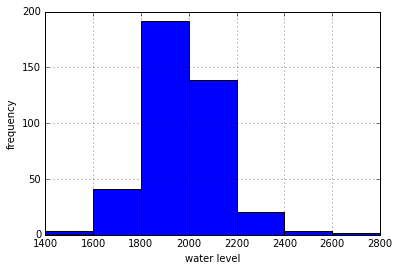

In [46]:
freq = [3, 41, 192, 139, 20, 3, 1, 1]
x = []
for i in range(len(freq)):
    x += [(i*200 + 1400)] * freq[i]
    
# the histogram of the data
plt.hist(x, bins=[n*200+1400 for n in range(len(freq))])
plt.xlabel('water level')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

In [12]:
a = np.array([
    [0,1,0],
    [1,0,1],
    [1,1,1]])

b = np.array([
    ['e', 'x', '1'], 
    ['e', 'x', '2']])

b[a]

array([[['e', 'x', '1'],
        ['e', 'x', '2'],
        ['e', 'x', '1']],

       [['e', 'x', '2'],
        ['e', 'x', '1'],
        ['e', 'x', '2']],

       [['e', 'x', '2'],
        ['e', 'x', '2'],
        ['e', 'x', '2']]],
      dtype='<U1')